In [237]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sklearn as sk
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import optuna
import xgboost as xgb

In [2]:
crime_df = pd.read_csv("../data/clean_crime_df.csv")
staff_df = pd.read_csv("../data/clean_staff_df.csv")


In [3]:
crime_df.head()

,Call Date,call_time,District,Sector,Call Type,year,month,day,call_hour,month_day,priority,month_num
0,2020-01-01,00:05:46,2,21,UNKNOWN TROUBLE,2020,Jan,1,0,Jan-01,high,1
1,2020-01-01,02:06:01,4,44,ASSAULT IN PROGRESS,2020,Jan,1,2,Jan-01,high,1
2,2020-01-01,00:37:32,5,55,FIRE,2020,Jan,1,0,Jan-01,high,1
3,2020-01-01,01:41:30,5,55,CHECK WELFARE,2020,Jan,1,1,Jan-01,medium,1
4,2020-01-01,00:46:26,1,13,DOMESTIC VIOLENCE,2020,Jan,1,0,Jan-01,high,1


In [4]:
staff_df.head()

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7


In [16]:
staff_df['Exception Start Time'].unique()

array(['07:00:00', '19:00:00', '17:00:00', '05:00:00', '08:00:00',
       '12:30:00', '15:00:00', '21:00:00', '18:00:00', '06:00:00',
       '22:00:00', '14:00:00', '13:00:00', '12:00:00', '00:00:00',
       '02:00:00', '01:00:00', '04:00:00', '03:00:00', '16:00:00',
       '11:00:00', '08:30:00', '09:00:00', '09:30:00', '21:30:00',
       '23:00:00', '15:30:00', '16:30:00', '03:30:00', '01:30:00',
       '04:30:00', '13:30:00', '21:45:00', '00:30:00', '20:00:00',
       '17:30:00', '22:30:00', '14:30:00', '10:00:00', '10:45:00',
       '19:30:00', '11:30:00', '07:30:00', '23:30:00', '18:30:00',
       '05:30:00', '00:45:00', '02:30:00', '20:30:00', '09:15:00',
       '16:45:00', '06:30:00', '18:45:00', '16:15:00', '03:45:00',
       '01:45:00'], dtype=object)

In [21]:
'07:30:0' < '07:00:00'

False

In [22]:
def shifts(x):
    
    if x < '07:00:00':
        return 'night'
    elif x <  '15:00:00':
        return 'day'
    elif x < '23:00:00' :
        return 'evening'
    else:
        return 'night'

In [23]:
staff_df['shift'] = staff_df['Exception Start Time'].apply(shifts)
staff_df

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day
...,...,...,...,...,...,...,...,...,...,...,...,...
28369,4 District C Platoon,38160,2022-12-22,18:00:00,12.0,Sick,2022,Dec,22,Dec-22,18,evening
28370,4 District D Platoon,37350,2022-12-22,07:00:00,12.0,Vacation,2022,Dec,22,Dec-22,7,day
28371,4 District D Platoon,37350,2022-12-30,07:00:00,6.0,Vacation,2022,Dec,30,Dec-30,7,day
28372,4 District D Platoon,37350,2022-12-31,19:00:00,12.0,Vacation,2022,Dec,31,Dec-31,19,evening


In [28]:
# seasonality
def seasonality(date):
    """
    Return the season given the date.

    date: Exception date 
    
    date thresholds are referenced from
    https://www.timeanddate.com/calendar/seasons.html
    """
    date = str(date)
    if date < "2020-03-19":
        return "winter"
    
    elif date < "2020-06-20":
        return "spring"
    
    elif date < "2020-09-22":
        return "summer"
    
    elif date < "2020-12-21":
        return "fall"
    
    elif date < "2021-03-20":
        return "winter"
    
    elif date < "2021-06-20":
        return "spring"
    
    elif date < "2021-09-22":
        return "summer"
    
    elif date < "2021-12-21":
        return "fall"
    
    elif date < "2022-03-20":
        return "winter"
    
    elif date < "2022-06-21":
        return "spring"
    
    elif date < "2022-09-22":
        return "summer"
    
    elif date < "2022-12-21":
        return "fall"
    
    else:
        return "winter"
    

staff_df['season'] = staff_df['Exception Date'].apply(seasonality)

staff_df.head()

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift,season
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day,winter
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day,winter
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day,winter
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day,winter
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day,winter


In [39]:
staff_df['month_num'] = staff_df['Exception Date'].apply(lambda x: x[5:7]).apply(int)

In [40]:
staff_df

,Platoon,Officer Badge #,Exception Date,Exception Start Time,# of Hours,Exception Type,year,month,day,month_day,hour,shift,season,month_num
0,4 District B Platoon,34260,2020-02-27,07:00:00,12.0,Vacation,2020,Feb,27,Feb-27,7,day,winter,2
1,4 District B Platoon,34260,2020-02-20,07:00:00,10.0,Training,2020,Feb,20,Feb-20,7,day,winter,2
2,4 District B Platoon,34260,2020-02-19,07:00:00,10.0,Training,2020,Feb,19,Feb-19,7,day,winter,2
3,4 District B Platoon,34260,2020-03-07,07:00:00,12.0,Sick,2020,Mar,7,Mar-07,7,day,winter,3
4,4 District B Platoon,34260,2020-02-28,07:00:00,12.0,Vacation,2020,Feb,28,Feb-28,7,day,winter,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28369,4 District C Platoon,38160,2022-12-22,18:00:00,12.0,Sick,2022,Dec,22,Dec-22,18,evening,winter,12
28370,4 District D Platoon,37350,2022-12-22,07:00:00,12.0,Vacation,2022,Dec,22,Dec-22,7,day,winter,12
28371,4 District D Platoon,37350,2022-12-30,07:00:00,6.0,Vacation,2022,Dec,30,Dec-30,7,day,winter,12
28372,4 District D Platoon,37350,2022-12-31,19:00:00,12.0,Vacation,2022,Dec,31,Dec-31,19,evening,winter,12


In [82]:
staff_df['Exception Type'].value_counts() /staff_df.shape[0]

Exception Type
Vacation    0.631917
Training    0.224149
Sick        0.143935
Name: count, dtype: float64

In [216]:
cat_preds = staff_df[['shift','season']]
num_preds = staff_df[['# of Hours', 'month_num','day','hour']]

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(cat_preds)

# get label y values
label_encoder = LabelEncoder()


label_encoder.fit(staff_df['Exception Type'])

LabelEncoder()

In [238]:
X

,# of Hours,month_num,day,hour,shift,season
0,12.0,2,27,7,day,winter
1,10.0,2,20,7,day,winter
2,10.0,2,19,7,day,winter
3,12.0,3,7,7,day,winter
4,12.0,2,28,7,day,winter
...,...,...,...,...,...,...
28369,12.0,12,22,18,evening,winter
28370,12.0,12,22,7,day,winter
28371,6.0,12,30,7,day,winter
28372,12.0,12,31,19,evening,winter


In [171]:
X = staff_df[['# of Hours', 'month_num','day','hour','shift','season']]
Y_unlabeled= staff_df['Exception Type']

In [194]:
# train test split
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y_unlabeled, 
                                                                    random_state=888, 
                                                                    test_size=0.20)


# make sure indexes are correct
train_df = pd.concat([x_train,y_train],axis=1)


# over sample

n = 2000

extra_sick = train_df[
        train_df['Exception Type'] == 'Sick'
        ].sample(n, random_state= 888)


train_over_sample = pd.concat([train_df, extra_sick], axis=0)
train_over_sample


# training
x_train = train_over_sample[['# of Hours', 'month_num',
                   'day','hour','shift','season']]
y_train = train_over_sample['Exception Type']

cat_preds = x_train[['shift','season']]
num_preds = x_train[['# of Hours', 'month_num','day','hour']]

cat_preads = enc.transform(cat_preds).toarray()
cat_preds = pd.DataFrame(cat_preds, index = num_preds.index)
x_train = pd.concat([num_preds,cat_preds],axis=1)


y_train = pd.DataFrame(label_encoder.transform(y_train))


# testing
cat_preds = x_test[['shift','season']]
num_preds = x_test[['# of Hours', 'month_num','day','hour']]

cat_preds = enc.transform(cat_preds).toarray()
cat_preds = pd.DataFrame(cat_preds, index = num_preds.index)
x_test = pd.concat([num_preds,cat_preds],axis=1)

y_test = pd.DataFrame(label_encoder.transform(y_test))


In [225]:
#Start of gradient boosted tree

xgb_model = xgb.XGBClassifier(n_estimators=5000) # initialize tree

xgb_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)


print(classification_report(prob_preds[0], prob_preds['y_pred']))

              precision    recall  f1-score   support

           0       0.37      0.25      0.30       841
           1       0.95      0.96      0.95      1279
           2       0.83      0.89      0.86      3555

    accuracy                           0.81      5675
   macro avg       0.72      0.70      0.70      5675
weighted avg       0.79      0.81      0.80      5675



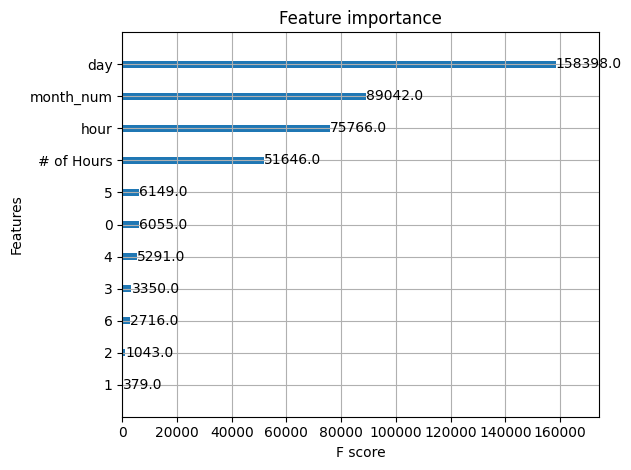

In [230]:
plot_importance(xgb_model)
plt.tight_layout()

In [227]:
predict_xgb = xgb_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)


print(classification_report(prob_preds[0], prob_preds['y_pred']))

              precision    recall  f1-score   support

           0       0.37      0.25      0.30       841
           1       0.95      0.96      0.95      1279
           2       0.83      0.89      0.86      3555

    accuracy                           0.81      5675
   macro avg       0.72      0.70      0.70      5675
weighted avg       0.79      0.81      0.80      5675



In [196]:
def find_max_and_assign(row):
    # Extract the values for 'Sick', 'Training', and 'Vacation'
    values = row[['Sick', 'Training', 'Vacation']]
    
    # Find the column with the maximum value
    max_col = values.idxmax()
    
    # Assign the new value to 'Predictions' based on the max column
    if max_col == 'Sick':
        return 0
    elif max_col == 'Training':
        return 1
    elif max_col == 'Vacation':
        return 2

In [234]:
report = classification_report(prob_preds[0], prob_preds['y_pred'], output_dict=True)

report['0']['recall']
report['1']['recall']
report['2']['recall']

0.8928270042194093

In [236]:
report

{'0': {'precision': 0.37168141592920356,
  'recall': 0.2497027348394768,
  'f1-score': 0.2987197724039829,
  'support': 841},
 '1': {'precision': 0.9481424148606811,
  'recall': 0.9577795152462861,
  'f1-score': 0.9529366005445352,
  'support': 1279},
 '2': {'precision': 0.8313253012048193,
  'recall': 0.8928270042194093,
  'f1-score': 0.8609792486097925,
  'support': 3555},
 'accuracy': 0.81215859030837,
 'macro avg': {'precision': 0.7170497106649013,
  'recall': 0.7001030847683908,
  'f1-score': 0.7042118738527702,
  'support': 5675},
 'weighted avg': {'precision': 0.7895365048786614,
  'recall': 0.81215859030837,
  'f1-score': 0.7983806994706647,
  'support': 5675}}

In [215]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=True)


  0%|          | 0/20 [00:00<?, ?it/s]

1
[0]	validation_0-mlogloss:1.09456


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.53780
[1000]	validation_0-mlogloss:0.51154
[1500]	validation_0-mlogloss:0.50295
[2000]	validation_0-mlogloss:0.49775
[2500]	validation_0-mlogloss:0.49397
[3000]	validation_0-mlogloss:0.49115
[3500]	validation_0-mlogloss:0.48876
[3999]	validation_0-mlogloss:0.48676
1
[0]	validation_0-mlogloss:1.08681


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50477
[1000]	validation_0-mlogloss:0.48934
[1499]	validation_0-mlogloss:0.48129
1
[0]	validation_0-mlogloss:1.08978


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50986
[1000]	validation_0-mlogloss:0.49308
[1500]	validation_0-mlogloss:0.48547
[2000]	validation_0-mlogloss:0.48021
[2500]	validation_0-mlogloss:0.47616
[3000]	validation_0-mlogloss:0.47292
[3500]	validation_0-mlogloss:0.47011
[4000]	validation_0-mlogloss:0.46770
[4500]	validation_0-mlogloss:0.46559
[4999]	validation_0-mlogloss:0.46367
1
[0]	validation_0-mlogloss:1.08523


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.48678
[1000]	validation_0-mlogloss:0.47013
[1500]	validation_0-mlogloss:0.46093
[1999]	validation_0-mlogloss:0.45451
1
[0]	validation_0-mlogloss:1.08914


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.44929
[1000]	validation_0-mlogloss:0.42479
[1500]	validation_0-mlogloss:0.41334
[2000]	validation_0-mlogloss:0.40552
[2499]	validation_0-mlogloss:0.39950
1
[0]	validation_0-mlogloss:1.09385


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-mlogloss:0.57926
1
[0]	validation_0-mlogloss:1.09336


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.52442
[1000]	validation_0-mlogloss:0.49541
[1500]	validation_0-mlogloss:0.48536
[2000]	validation_0-mlogloss:0.47981
[2500]	validation_0-mlogloss:0.47573
[2999]	validation_0-mlogloss:0.47232
1
[0]	validation_0-mlogloss:1.08563


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[499]	validation_0-mlogloss:0.52042
1
[0]	validation_0-mlogloss:1.08832


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51879
[1000]	validation_0-mlogloss:0.50333
[1500]	validation_0-mlogloss:0.49522
[2000]	validation_0-mlogloss:0.48961
[2500]	validation_0-mlogloss:0.48537
[3000]	validation_0-mlogloss:0.48187
[3500]	validation_0-mlogloss:0.47897
[3999]	validation_0-mlogloss:0.47644
1
[0]	validation_0-mlogloss:1.08595


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50225
[1000]	validation_0-mlogloss:0.48739
[1500]	validation_0-mlogloss:0.47992
[2000]	validation_0-mlogloss:0.47466
[2500]	validation_0-mlogloss:0.47072
[3000]	validation_0-mlogloss:0.46737
[3500]	validation_0-mlogloss:0.46452
[4000]	validation_0-mlogloss:0.46193
[4500]	validation_0-mlogloss:0.45983
[4999]	validation_0-mlogloss:0.45781
1
[0]	validation_0-mlogloss:1.09465


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.54680
[1000]	validation_0-mlogloss:0.52256
[1500]	validation_0-mlogloss:0.51399
[2000]	validation_0-mlogloss:0.50864
[2500]	validation_0-mlogloss:0.50479
[3000]	validation_0-mlogloss:0.50195
[3499]	validation_0-mlogloss:0.49950
1


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.08808
[500]	validation_0-mlogloss:0.50629
[1000]	validation_0-mlogloss:0.49269
[1499]	validation_0-mlogloss:0.48583
1
[0]	validation_0-mlogloss:1.09133


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51560
[1000]	validation_0-mlogloss:0.49508
[1499]	validation_0-mlogloss:0.48622
1
[0]	validation_0-mlogloss:1.08666


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.49800
[1000]	validation_0-mlogloss:0.48158
[1500]	validation_0-mlogloss:0.47282
[2000]	validation_0-mlogloss:0.46665
[2500]	validation_0-mlogloss:0.46181
[3000]	validation_0-mlogloss:0.45782
[3500]	validation_0-mlogloss:0.45444
[3999]	validation_0-mlogloss:0.45151
1
[0]	validation_0-mlogloss:1.09455


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51921
[1000]	validation_0-mlogloss:0.48781
[1499]	validation_0-mlogloss:0.47695
1
[0]	validation_0-mlogloss:1.09329


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.56936
[1000]	validation_0-mlogloss:0.53753
[1500]	validation_0-mlogloss:0.52905
[2000]	validation_0-mlogloss:0.52467
[2500]	validation_0-mlogloss:0.52148
[3000]	validation_0-mlogloss:0.51887
[3500]	validation_0-mlogloss:0.51658
[3999]	validation_0-mlogloss:0.51461
1
[0]	validation_0-mlogloss:1.09518


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.55508
[1000]	validation_0-mlogloss:0.52606
[1500]	validation_0-mlogloss:0.51660
[2000]	validation_0-mlogloss:0.51072
[2500]	validation_0-mlogloss:0.50659
[2999]	validation_0-mlogloss:0.50361
1
[0]	validation_0-mlogloss:1.08402


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.50961
[1000]	validation_0-mlogloss:0.49513
[1500]	validation_0-mlogloss:0.48777
[2000]	validation_0-mlogloss:0.48266
[2499]	validation_0-mlogloss:0.47884
1
[0]	validation_0-mlogloss:1.09298


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.52522
[999]	validation_0-mlogloss:0.50134
1
[0]	validation_0-mlogloss:1.09256


/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
/var/folders/wj/gwqv8kfj18317lgnlmf6zypw0000gn/T/ipykernel_1406/184723262.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
/Users/kennethleung/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-mlogloss:0.51296
[1000]	validation_0-mlogloss:0.48213
[1500]	validation_0-mlogloss:0.47232
[2000]	validation_0-mlogloss:0.46623
[2500]	validation_0-mlogloss:0.46131
[3000]	validation_0-mlogloss:0.45723
[3500]	validation_0-mlogloss:0.45371
[4000]	validation_0-mlogloss:0.45041
[4499]	validation_0-mlogloss:0.44758


In [217]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best objective value:', study.best_value)

Number of finished trials: 20
Best trial: {'lambda': 0.5638673580858264, 'alpha': 0.00882913704049085, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 166}
Best objective value: 0.6281676210211776


In [222]:
best_params = {'lambda': 0.5638673580858264, 'alpha': 0.00882913704049085, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.014, 'n_estimators': 4000, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 166}

opt_model = xgb.XGBClassifier(**best_params)

opt_model.fit(x_train, np.ravel(y_train)) # train tree

predict_xgb = opt_model.predict_proba(x_test) # 1st col = pred val, 2nd col = pred prob

predict_xgb_prob = pd.DataFrame(predict_xgb,columns = ['Sick','Training', 'Vacation'])

prob_preds = pd.concat([predict_xgb_prob, y_test.reset_index(drop=True)],axis=1)

prob_preds['y_pred'] = prob_preds.apply(find_max_and_assign,axis=1)


print(classification_report(prob_preds[0], prob_preds['y_pred']))

              precision    recall  f1-score   support

           0       0.47      0.17      0.25       841
           1       0.93      0.96      0.95      1279
           2       0.82      0.94      0.88      3555

    accuracy                           0.83      5675
   macro avg       0.74      0.69      0.69      5675
weighted avg       0.80      0.83      0.80      5675

